# Non-linear Breit-Wheeler pair creation

The pair production rate can be written as follows:

$$ 
\frac{d^2N_{BW}}{d\chi_\pm dt} =  \frac{\alpha_f m_e^2 c^4}{\pi \sqrt{3} \hbar \epsilon_\gamma \chi_\gamma} 
\int_x^{+\infty} \sqrt{s} K_{1/3}\left({\frac{2}{3} s^{3/2}}\right) ds - \left({ 2 - \chi_\gamma^{3/2} }\right) K_{2/3} \left({\frac{2}{3} x^{3/2}}\right) 
$$

where $x = \left( \chi_\gamma / (\chi_- \chi_+) \right)^{2/3}$.

When I ask sympy to peform the integral, it remains stuck forever...

In [1]:
from sympy import *
s = Symbol('s')
func = besselk(1/3, 2/3 * s**(3/2))*sqrt(s)
#print(integrate(func, s))Don't do that

However Wolfram Alpha provides an explicit form for the solution:

$$ 
\int \sqrt{s} K_{1/3}\left({\frac{2}{3} s^{3/2}}\right) ds = \\
\frac{
3^{5/6} \pi ~ s ~ \Gamma\left({\frac{1}{3}}\right) \Gamma\left({\frac{5}{3}}\right) 
\phantom{f}_1F_2\left({ \frac{1}{3}; \frac{2}{3}, \frac{4}{3}; \frac{s^3}{9}}\right)
-
3^{1/6} \pi ~ s^2 ~ \Gamma\left({\frac{2}{3}}\right)^2 
\phantom{f}_1F_2\left({ \frac{2}{3}; \frac{4}{3}, \frac{5}{3}; \frac{s^3}{9}}\right)
}
{9 \Gamma\left({\frac{2}{3}}\right) \Gamma\left({\frac{4}{3}}\right) \Gamma\left({\frac{5}{3}}\right)}
$$

If we find a good open source implementation of generalized hypergeometric functions, we could exploit this in the code.

Anyway, this notebook contains implementations of the pair production rate functions, in order to perform quick test of the library. Let's start with some useful definitions (for code units we use same normalization as smilei):

In [115]:
import math as m
import numpy as np

electron_mass = 9.10938356e-31
elementary_charge = 1.6021766208e-19
speed_of_light = 299792458
reduced_plank = 1.054571800e-34
vacuum_permittivity =  8.854187817e-12
fine_structure_constant =  0.0072973525664

lambda_laser = 1e-6

schwinger_field_SI = electron_mass**2 * speed_of_light**3 / (reduced_plank*elementary_charge)
print('Schiwinger field in SI units is: ' + str(schwinger_field_SI))

schwinger_field_code_units = electron_mass*speed_of_light*lambda_laser/(2.0*reduced_plank*m.pi)
print('Schiwinger field in code units is: ' + str(schwinger_field_code_units))

conversion_of_rate_from_code_to_SI = (2.0 * m.pi * speed_of_light)/lambda_laser
print('Conv. factors for prod. rate from code units to SI: ' + str(conversion_of_rate_from_code_to_SI))

Schiwinger field in SI units is: 1.3232854660718482e+18
Schiwinger field in code units is: 412148.44880773965
Conv. factors for prod. rate from code units to SI: 1883651567308853.2


Let's define the $\chi_\gamma $ function. We will assume that all these quantities are provided in code units (same normalization as Smilei)

In [121]:
def calc_chi_gamma(p, E, B):
    gamma_phot = np.linalg.norm(p)  
    c = p/gamma_phot  
    loc_field = gamma_phot * np.linalg.norm( E - np.dot(c,E)*c + np.cross(c,B))     
    return loc_field/schwinger_field_code_units

#A quick tests

calc_chi_gamma(np.array([195.417, 128.709, -43.351]), np.array([-154.214, 199.139, 197.890]), np.array([40.676, 12.243, 42.457]))

calc_chi_gamma(np.array([1000, 0, 0]), np.array([0, 0, 0]), np.array([0, 0, 500]))

1.2131551178862781

We now define 

$$
inner(x) = \int_x^{+\infty} \sqrt{s} K_{1/3}\left({\frac{2}{3} s^{3/2}}\right) ds
$$

and 

$$
X(\chi_\gamma, \chi_-) = \left( \frac{\chi_\gamma}{\chi_- (\chi_\gamma - \chi_- )}   \right)^{2/3}
$$

and

$$
T(\chi_\gamma) = \frac{1}{\pi \sqrt{3} \chi^2_\gamma} \int_0^{+\infty} inner\left({X(\chi_\gamma, \chi_-)}\right) - \left({ 2 - \chi_\gamma^{3/2} }\right) K_{2/3} \left({\frac{2}{3} X(\chi_\gamma, \chi_-)^{3/2}}\right) d\chi_-
$$

In [111]:
import scipy.special as spe
import scipy.integrate as integ

def inner(x):
    return integ.quad(lambda s: np.sqrt(s)*spe.kv(1./3., 2./3. * s**(3./2.)), x, np.inf)[0] 

inner = np.vectorize(inner)

def X(chi_phot, chi_ele):
    if (chi_phot > chi_ele):
        return np.power(chi_phot/(chi_ele*(chi_phot-chi_ele)), 2./3.)        
    else:
        return 10.0e30

X = np.vectorize(X)

def T(chi_phot):
    coeff = 1./(np.pi * np.sqrt(3) * chi_phot * chi_phot)
    return integ.quad(lambda chi_ele: 
                      coeff*(inner(X(chi_phot, chi_ele)) - 
                      (2.0 - chi_phot*np.power(X(chi_phot, chi_ele), 3./2.))*spe.kv(2./3., 2./3. *X(chi_phot, chi_ele)**(3./2.)) )
                      , 0, chi_phot)[0] 
T = np.vectorize(T)
    

We can now write the total production rate as:

$$
\frac{dN_{BW}}{dt} = \frac{\alpha_f m_e^2 c^4}{\hbar \epsilon_\gamma} \chi_\gamma T(\chi_\gamma)
$$

we also note that $\epsilon_\gamma / m_e c^2$ is the  photon energy in code units.
So we can write the following function, which gives the total production rate *in SI units* as a function of quantities *in code units*. 

In [114]:
def dNBW_dt(chi_phot, e_phot):
    val = ((electron_mass*(speed_of_light)**2)*fine_structure_constant/reduced_plank)*(chi_phot/e_phot)*T(chi_phot)
    return val*conversion_of_rate_from_code_to_SI

px = 8000
chi = calc_chi_gamma(np.array([px,0,0]),np.array([0,500,0]),np.array([0,0,0]))
rate = dNBW_dt(calc_chi_gamma(np.array([px,0,0]),np.array([0,500,0]),np.array([0,0,0])), px)
print(str(chi) + " " + str(rate) + " " + str(rate/1e18))

9.70524094309 1.40235690594e+30 1.40235690594e+12


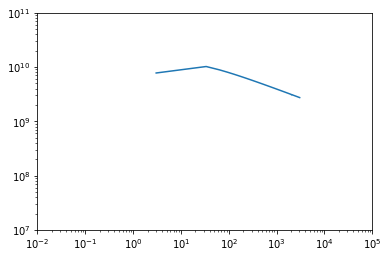

In [83]:
px = np.linspace(2000,2000000,num=100)

def ff(px):
    return dNBW_dt(calc_chi_gamma(np.array([px,0,0]),np.array([0,500,0]),np.array([0,0,0])), px)

ff = np.vectorize(ff)

def cc(px):
    return calc_chi_gamma(np.array([px,0,0]),np.array([0,500,0]),np.array([0,0,0]))

cc = np.vectorize(cc)

ff(px)

import matplotlib.pyplot as plt

plt.loglog(cc(px), ff(px)*1e-18)
axes = plt.gca()
axes.set_xlim([0.01,100000])
axes.set_ylim([1e7,1e11])
plt.show()